In [1]:
using Pkg
Pkg.activate(".")

using JLD2, Plots, Lux, QuadGK, ComponentArrays, PhasorNetworks

  Activating project at `~/code/phasor_julia`


# Load the test data

In [2]:
include("train_classifier.jl")
data_dir = "pixel_data/"
file_pairs = get_dataset(data_dir)

  Activating project at `~/code/phasor_julia`


10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [3]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [4]:
n_test = 10000

10000

In [5]:
q = q_test[:, :, :, 1:n_test]
yl = ylocal_test[1:n_test]
pt = pt_test[1:n_test];

# Load the trained networks

In [6]:
ids = 43:48 |> collect;

In [7]:
function auroc(trained, call_fn)
    global pt
    pth = call_fn(trained)
    roc = tpr_fpr(pth, pt)
    roc_u = average_duplicate_knots(roc[2], roc[1])
    roc_fn = linear_interpolation(roc_u...)
    auroc = quadgk(roc_fn, 0.0, 1.0)[1]
    return auroc
end

auroc (generic function with 1 method)

In [8]:
mlps = [load("trained_nns/mlp_id_" * string(id) * "_epoch_100.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (scale = Float32[0.84043115, 1.2591363, 1.7509029, 1.6067656, 1.2224876, 1.183681, 1.3597107, 1.7909936, 1.9222077, 0.5121033, 0.35439044, 0.46825647, 0.15563248, 0.60759217], bias = Float32[-0.15679184, 0.007983687, 0.34967747, 0.5587814, 0.54680705, 0.6282297, 0.58878344, 0.371983, 0.020967497, -0.30517352, -0.24793093, -0.03700212, -0.32763767, 0.07363863]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.26534644 0.16762076 … 0.2233943 0.8040235; 0.114862956 0.055006634 … -0.1330096 -0.5745751; … ; -0.26862222 0.023581494 … -0.15008631 -0.49673986; -0.030385466 0.08127815 … -0.052740205 -0.410357], bias = Float32[0.11983151; 0.2736901; … ; 0.14855553; -0.056346085;;]), layer_4 = (weight = Float32[-0.91825676 -0.09599364 … -0.008247511 -0.18569079; 0.28259072 0.5849801 … 0.5030338 -0.36946005; 0.15059568 -0.26762253 … -0.3119786 0.25879323], bias = Float32[0.025180005; 0.09040724; -0.048583783;;])), "state" => (la

In [9]:
function predict_mlp(trained)
    params = trained["params"]
    state = trained["state"]
    global q
    global yl

    pred, _ = mlp_model(process_inputs_mlp(q, yl), params, state)
    return pred
end

predict_mlp (generic function with 1 method)

In [10]:
pth = predict_mlp(mlps[1])

3×10000 Matrix{Float64}:
 -1.03936  -1.2827    -1.36365   …  -1.17661   -1.94372   -0.867384
 -1.20626  -0.365469   1.2509        0.156264  -0.174552   0.85686
  1.5732    1.06693   -0.822588      1.63345    1.201      0.590607

In [12]:
auroc_mlp = x -> auroc(x, predict_mlp)

#64 (generic function with 1 method)

In [13]:
auroc_mlps = auroc_mlp.(mlps)

6-element Vector{Float64}:
 0.8619534200418385
 0.8643762766615558
 0.8537256897336294
 0.8663365019548579
 0.8657329658315501
 0.857021721103633

In [14]:
pmlps = [load("trained_nns/pmlp_id_" * string(id) * "_epoch_100.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (scale = Float32[0.4611713, 0.7945772, 1.0455916, 0.9466239, 0.9983645, 0.7986385, 1.0625937, 1.076156, 1.085038, 0.17968072, 0.21605618, 0.16161042, 0.089231364, 0.3393442], bias = Float32[-0.30808827, 0.103240624, 0.27551818, 0.5620901, 0.28622818, 0.5678, 0.15927714, 0.38617665, -0.0020063354, 0.12638877, -0.105870426, -0.116136976, 0.027554784, 0.33653456]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.05868069 -0.034977213 … 0.44358674 0.27405196; 0.10406588 0.0152126 … 0.019462781 -0.17392358; … ; -0.05868901 0.17384061 … 0.021038758 -0.031678833; -0.20989293 0.22455822 … -0.078325585 0.09693501], bias = ComplexF32[0.97786313f0 + 0.024052907f0im, 1.000072f0 + 0.0338428f0im, 0.89760166f0 + 0.086402066f0im, 0.98783225f0 - 0.013903405f0im, 1.0128567f0 + 0.009071913f0im, 0.96993476f0 - 0.11209156f0im, 0.9854144f0 + 0.08480665f0im, 1.0044348f0 + 0.0305721f0im, 1.0157015f0 + 0.0050732377f0im, 0.9813482f0 + 0.04

In [15]:
function predict_pmlp(trained)
    params = trained["params"]
    state = trained["state"]
    global q
    global yl

    pred, _ = pmlp_model(process_inputs_pmlp(q, yl), params, state)
    return pred
end

predict_pmlp (generic function with 1 method)

In [16]:
auroc_pmlp = x -> auroc(x, predict_pmlp)

#68 (generic function with 1 method)

In [17]:
auroc_pmlps = auroc_pmlp.(pmlps)

6-element Vector{Float64}:
 0.8605386095822394
 0.8638571250694578
 0.8615896199642874
 0.8607985962709583
 0.8617175273266207
 0.8603635315040855

In [18]:
function predict_ode(trained)
    params = trained["params"]
    state = trained["state"]
    global q
    global yl
    x_tms = range(start=0.0, stop=1.0, length=size(q, 1)) |> collect
    sa = SpikingArgs()

    pred, _ = ode_model(process_inputs_ode(q, x_tms, yl, sa), params, state)
    return pred
end

predict_ode (generic function with 1 method)

In [19]:
auroc_ode = x -> auroc(x, predict_ode)

#70 (generic function with 1 method)

In [20]:
odes = [load("trained_nns/ode_id_" * string(id) * "_epoch_100.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (layer_1 = (scale = Float32[0.43917143, 0.59332305, 1.1782515, 0.775691, 0.72227293, 0.81135553, 0.739171, 1.2555801, 0.9735569, 0.51992846, 0.3512906, 0.27210677, 0.24401292, 1.3215605], bias = Float32[0.075470425, 0.06778238, 0.14230376, 0.46055245, 0.08737187, -0.3214328, -0.0773752, 0.33881742, -0.023806224, -0.31041446, -0.08103792, -0.39755595, -0.7092467, -0.2268188]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.29947186 -0.08752234 … 0.29842618 0.014016382; -0.057423312 0.2113529 … 0.08724561 -0.14189853; … ; -0.2690506 0.11443567 … -0.04676603 -0.4082051; -0.097704284 0.29706156 … 0.008971594 -0.18657108], bias = Float32[-0.124491245; 0.105362825; … ; 0.17360234; -0.24308023;;])), layer_2 = Float32[], layer_3 = (weight = Float32[-0.13096224 0.045193493 … -0.5094432 -0.77739894; -0.17366232 -0.4190624 … -1.0947211 1.2366433; 0.3605523 0.3669498 … 0.6905874 -0.16878554], bias_real = Float32[11.99454, 0.510

In [21]:
auroc_odes = auroc_ode.(odes)

6-element Vector{Float64}:
 0.8569622280373509
 0.8549685934018622
 0.8563727238498283
 0.8580022247503616
 0.8597897911841663
 0.8553145649037301

In [22]:
using StatsPlots

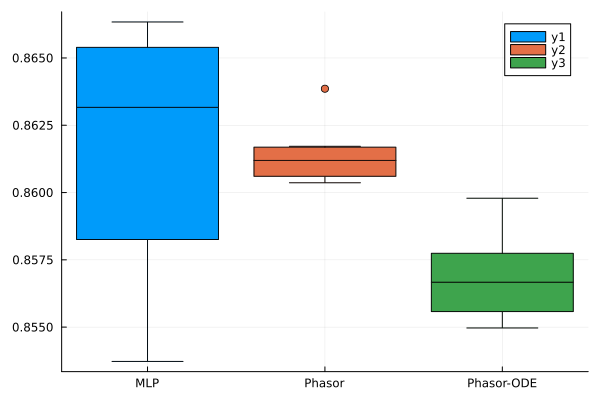

In [23]:
boxplot(stack((auroc_mlps, auroc_pmlps, auroc_odes), dims=2))
xticks!([1.0, 2.0, 3.0], ["MLP", "Phasor", "Phasor-ODE"])